In [14]:
# Ethereum Transaction Graph Analysis
# Load required libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Load the Ethereum transaction data
df = pd.read_csv('ethereum_medium2.csv')

print("Data loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

print(f" num nodes: {len(df['from_address'].unique())} and num edges: {len(df)}")



Data loaded successfully!
Dataset shape: (36182, 8)
Columns: ['hash', 'block_number', 'from_address', 'to_address', 'value', 'transaction_day', 'root_node', 'logic_path_taken']
 num nodes: 4480 and num edges: 36182


In [15]:
# Step 1: Sample 1000 random transactions for simple, fast training
import torch
from torch_geometric.data import Data
from torch_geometric.nn import TransformerConv
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm

# Sample 1000 random transactions
np.random.seed(42)
torch.manual_seed(42)

sample_size = 10000
df_sample = df.sample(n=min(sample_size, len(df)), random_state=42).reset_index(drop=True)

print(f"Sampled {len(df_sample)} transactions")
print(f"Unique source addresses: {df_sample['from_address'].nunique()}")
print(f"Unique target addresses: {df_sample['to_address'].nunique()}")
print(f"Total unique nodes: {len(set(df_sample['from_address'].unique()) | set(df_sample['to_address'].unique()))}")


Sampled 10000 transactions
Unique source addresses: 1808
Unique target addresses: 5689
Total unique nodes: 7419


In [16]:
# Step 2: Build simple graph structure
# Create node mapping
all_nodes = sorted(list(set(df_sample['from_address'].unique()) | set(df_sample['to_address'].unique())))
node_to_idx = {node: idx for idx, node in enumerate(all_nodes)}
num_nodes = len(all_nodes)

print(f"Graph has {num_nodes} nodes")

# Normalize edge attributes (transaction values) first
edge_value_scaler = StandardScaler()
edge_values = df_sample['value'].values.reshape(-1, 1)
edge_values_normalized = edge_value_scaler.fit_transform(edge_values)

# Build edge_index and edge_attr
edges = []
edge_attrs = []

for idx, row in df_sample.iterrows():
    from_node = row['from_address']
    to_node = row['to_address']
    
    from_idx = node_to_idx[from_node]
    to_idx = node_to_idx[to_node]
    
    edges.append([from_idx, to_idx])
    # Use normalized transaction value as edge attribute
    edge_attrs.append([edge_values_normalized[idx, 0]])

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_attrs, dtype=torch.float)

print(f"Graph has {edge_index.shape[1]} edges")
print(f"Edge index shape: {edge_index.shape}")
print(f"Edge attr shape: {edge_attr.shape}")


Graph has 7419 nodes
Graph has 10000 edges
Edge index shape: torch.Size([2, 10000])
Edge attr shape: torch.Size([10000, 1])


In [17]:
# Step 3: Prepare features - encode transaction_day and normalize values
# Convert transaction_day to datetime
df_sample['transaction_day'] = pd.to_datetime(df_sample['transaction_day'])

# Encode transaction_day as days since first transaction (simple temporal feature)
first_day = df_sample['transaction_day'].min()
df_sample['days_since_start'] = (df_sample['transaction_day'] - first_day).dt.days

# Normalize transaction values
value_scaler = StandardScaler()
values = df_sample['value'].values.reshape(-1, 1)
values_normalized = value_scaler.fit_transform(values).flatten()

# Normalize days feature
day_scaler = StandardScaler()
days = df_sample['days_since_start'].values.reshape(-1, 1)
days_normalized = day_scaler.fit_transform(days).flatten()

# Store normalized values and day features for each transaction
transaction_data = []
for idx, row in df_sample.iterrows():
    from_idx = node_to_idx[row['from_address']]
    to_idx = node_to_idx[row['to_address']]
    transaction_data.append({
        'from_idx': from_idx,
        'to_idx': to_idx,
        'value': values_normalized[idx],
        'value_original': float(row['value']),
        'day_feature': days_normalized[idx]
    })

print(f"Prepared {len(transaction_data)} transactions")
print(f"Value stats (normalized): min={values_normalized.min():.4f}, max={values_normalized.max():.4f}, mean={values_normalized.mean():.4f}")
print(f"Day feature stats (normalized): min={days_normalized.min():.4f}, max={days_normalized.max():.4f}, mean={days_normalized.mean():.4f}")


Prepared 10000 transactions
Value stats (normalized): min=-0.0338, max=50.0713, mean=-0.0000
Day feature stats (normalized): min=-3.6993, max=0.6859, mean=-0.0000


In [18]:
# Step 4: Define simple Graph Transformer model for value prediction
class SimpleValuePredictor(nn.Module):
    def __init__(self, num_nodes, hidden_dim=64, num_heads=2, num_layers=1):
        super(SimpleValuePredictor, self).__init__()
        self.num_nodes = num_nodes
        self.hidden_dim = hidden_dim
        
        # Node embedding layer
        self.node_embedding = nn.Embedding(num_nodes, hidden_dim)
        
        # Simple Graph Transformer layer (1-2 layers)
        self.convs = nn.ModuleList()
        if num_layers == 1:
            self.convs.append(TransformerConv(
                hidden_dim, hidden_dim, heads=num_heads,
                edge_dim=1, dropout=0.1, concat=True
            ))
            # Final layer to get fixed-size embeddings
            self.final_conv = TransformerConv(
                hidden_dim * num_heads, hidden_dim, heads=1,
                edge_dim=1, dropout=0.1, concat=False
            )
        else:
            self.convs.append(TransformerConv(
                hidden_dim, hidden_dim, heads=num_heads,
                edge_dim=1, dropout=0.1, concat=True
            ))
            for _ in range(num_layers - 1):
                self.convs.append(TransformerConv(
                    hidden_dim * num_heads, hidden_dim, heads=num_heads,
                    edge_dim=1, dropout=0.1, concat=True
                ))
            self.final_conv = TransformerConv(
                hidden_dim * num_heads, hidden_dim, heads=1,
                edge_dim=1, dropout=0.1, concat=False
            )
        
        # Value prediction head: [source_emb, target_emb, day_feature] -> value
        self.predictor = nn.Sequential(
            nn.Linear(hidden_dim * 2 + 1, hidden_dim),  # +1 for day feature
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )
    
    def forward(self, edge_index, edge_attr):
        """Get node embeddings from graph."""
        # Get all node indices
        all_node_indices = torch.arange(self.num_nodes, device=edge_index.device)
        
        # Get initial embeddings
        x = self.node_embedding(all_node_indices)
        
        # Apply transformer layers
        for conv in self.convs:
            x = conv(x, edge_index, edge_attr)
            x = F.relu(x)
        
        # Final layer
        x = self.final_conv(x, edge_index, edge_attr)
        
        return x
    
    def predict_value(self, source_emb, target_emb, day_feature):
        """Predict transaction value from embeddings and day feature."""
        # Concatenate: [source_emb, target_emb, day_feature]
        features = torch.cat([source_emb, target_emb, day_feature.unsqueeze(-1)], dim=-1)
        return self.predictor(features).squeeze()

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = SimpleValuePredictor(
    num_nodes=num_nodes,
    hidden_dim=64,
    num_heads=2,
    num_layers=1
).to(device)

print(f"\nModel initialized:")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Hidden dim: 64, Heads: 2, Layers: 1")


Using device: cpu

Model initialized:
  Parameters: 551,745
  Hidden dim: 64, Heads: 2, Layers: 1


In [20]:
# Step 5: Train/validation split and training loop
# Split data
train_data, val_data = train_test_split(transaction_data, test_size=0.2, random_state=42)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")

# Move graph to device
edge_index = edge_index.to(device)
edge_attr = edge_attr.to(device)

# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
num_epochs = 10
batch_size = 32
train_losses = []
val_losses = []

print("\nStarting training...")
for epoch in range(num_epochs):
    model.train()
    epoch_train_losses = []
    
    # Shuffle training data
    np.random.shuffle(train_data)
    
    # Batch training
    for i in range(0, len(train_data), batch_size):
        batch = train_data[i:i+batch_size]
        
        # Get node embeddings
        node_embeddings = model(edge_index, edge_attr)
        
        # Prepare batch data
        source_indices = torch.tensor([t['from_idx'] for t in batch], dtype=torch.long).to(device)
        target_indices = torch.tensor([t['to_idx'] for t in batch], dtype=torch.long).to(device)
        day_features = torch.tensor([t['day_feature'] for t in batch], dtype=torch.float).to(device)
        values = torch.tensor([t['value'] for t in batch], dtype=torch.float).to(device)
        
        # Get embeddings
        source_embs = node_embeddings[source_indices]
        target_embs = node_embeddings[target_indices]
        
        # Predict
        predictions = model.predict_value(source_embs, target_embs, day_features)
        
        # Loss
        loss = criterion(predictions, values)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_train_losses.append(loss.item())
    
    # Validation
    model.eval()
    with torch.no_grad():
        node_embeddings = model(edge_index, edge_attr)
        
        source_indices = torch.tensor([t['from_idx'] for t in val_data], dtype=torch.long).to(device)
        target_indices = torch.tensor([t['to_idx'] for t in val_data], dtype=torch.long).to(device)
        day_features = torch.tensor([t['day_feature'] for t in val_data], dtype=torch.float).to(device)
        values = torch.tensor([t['value'] for t in val_data], dtype=torch.float).to(device)
        
        source_embs = node_embeddings[source_indices]
        target_embs = node_embeddings[target_indices]
        
        val_predictions = model.predict_value(source_embs, target_embs, day_features)
        val_loss = criterion(val_predictions, values)
    
    train_loss = np.mean(epoch_train_losses)
    train_losses.append(train_loss)
    val_losses.append(val_loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss.item():.4f}")

print("\nTraining complete!")


Training samples: 8000
Validation samples: 2000

Starting training...
Epoch 10/10: Train Loss = 0.0849, Val Loss = 0.0316

Training complete!


Validation Results:
  RMSE: 6.51e+19
  MAE: 7.12e+18
  Mean actual value: 6.66e+18
  Mean predicted value: 3.18e+18


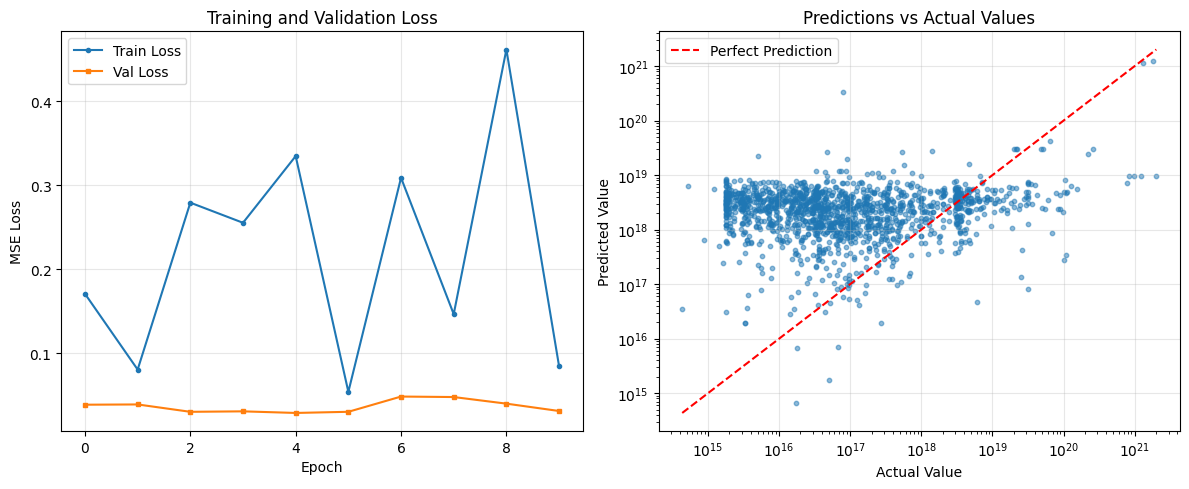


Final Training Statistics:
  Initial train loss: 0.1709
  Final train loss: 0.0849
  Initial val loss: 0.0391
  Final val loss: 0.0316


In [21]:
# Step 6: Evaluation with RMSE and MAE
model.eval()
with torch.no_grad():
    # Get final predictions on validation set
    node_embeddings = model(edge_index, edge_attr)
    
    source_indices = torch.tensor([t['from_idx'] for t in val_data], dtype=torch.long).to(device)
    target_indices = torch.tensor([t['to_idx'] for t in val_data], dtype=torch.long).to(device)
    day_features = torch.tensor([t['day_feature'] for t in val_data], dtype=torch.float).to(device)
    values_normalized = torch.tensor([t['value'] for t in val_data], dtype=torch.float).to(device)
    values_original = np.array([t['value_original'] for t in val_data])
    
    source_embs = node_embeddings[source_indices]
    target_embs = node_embeddings[target_indices]
    
    predictions_normalized = model.predict_value(source_embs, target_embs, day_features).cpu().numpy()
    
    # Denormalize predictions and values
    predictions_original = value_scaler.inverse_transform(predictions_normalized.reshape(-1, 1)).flatten()
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(values_original, predictions_original))
    mae = mean_absolute_error(values_original, predictions_original)
    
    print("Validation Results:")
    print(f"  RMSE: {rmse:.2e}")
    print(f"  MAE: {mae:.2e}")
    print(f"  Mean actual value: {values_original.mean():.2e}")
    print(f"  Mean predicted value: {predictions_original.mean():.2e}")

# Plot training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o', markersize=3)
plt.plot(val_losses, label='Val Loss', marker='s', markersize=3)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot predictions vs actual
plt.subplot(1, 2, 2)
plt.scatter(values_original, predictions_original, alpha=0.5, s=10)
plt.plot([values_original.min(), values_original.max()], 
         [values_original.min(), values_original.max()], 
         'r--', label='Perfect Prediction')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Predictions vs Actual Values')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log')
plt.yscale('log')

plt.tight_layout()
plt.show()

print(f"\nFinal Training Statistics:")
print(f"  Initial train loss: {train_losses[0]:.4f}")
print(f"  Final train loss: {train_losses[-1]:.4f}")
print(f"  Initial val loss: {val_losses[0]:.4f}")
print(f"  Final val loss: {val_losses[-1]:.4f}")


Sampling 10 random transactions from validation set...

PREDICTED vs REAL VALUES IN USD (10 Random Edges)
                    Edge  Actual Value (USD)  Predicted Value (USD)   Error (USD)       Error %
0  Node 2143 → Node 7192         9826.328153           11626.025391   1799.697237     18.315053
1     Node 6 → Node 7195         7115.153136          -10911.357422 -18026.510558   -253.353796
2  Node 3891 → Node 4291         1097.261216            1536.698364    439.437148     40.048545
3  Node 2552 → Node 3302          303.392000            7778.460938   7475.068938   2463.831920
4  Node 2552 → Node 1500          255.360000           12670.378906  12415.018906   4861.771188
5  Node 2552 → Node 3615          140.246843           12164.960938  12024.714094   8573.964176
6  Node 2173 → Node 5274           62.162011            5650.024414   5587.862403   8989.191783
7  Node 5850 → Node 1782           38.917661            2974.006836   2935.089175   7541.792397
8   Node 5850 → Node 885      

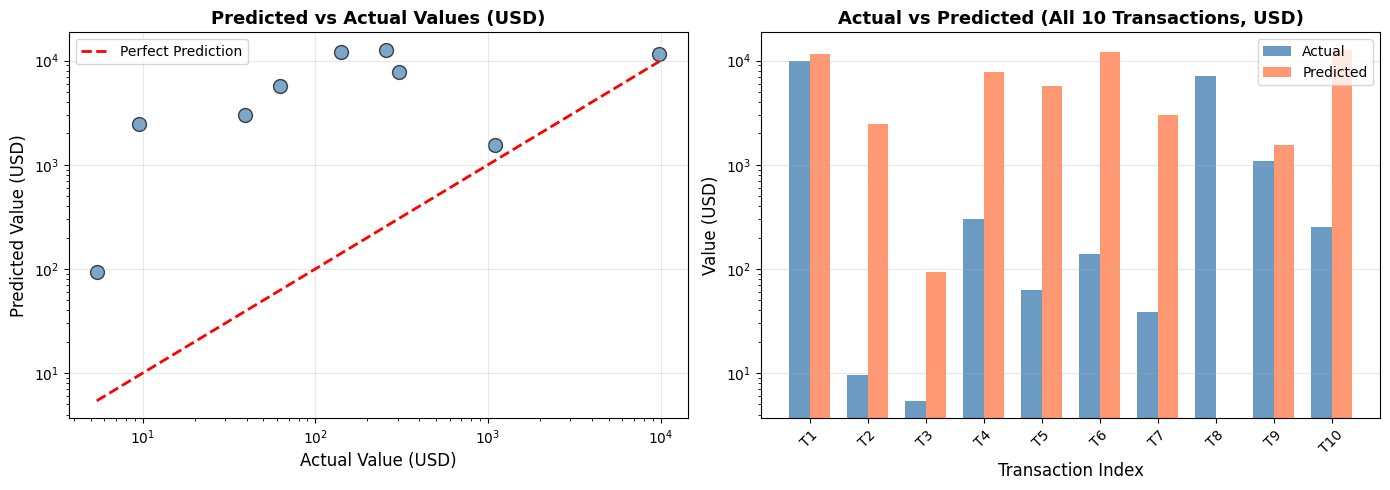

In [24]:
# Sample 10 random edges and compare predicted vs real values
# All values are converted to USD: value_in_usd = 3040 / 1e18 * value

import torch
import pandas as pd

usd_conversion_factor = 3040 / 1e18

# Sample 10 random transactions from validation set
np.random.seed(42)
sample_size = min(10, len(val_data))
random_indices = np.random.choice(len(val_data), sample_size, replace=False)
sample_transactions = [val_data[i] for i in random_indices]

print(f"Sampling {len(sample_transactions)} random transactions from validation set...\n")

# Run predictions
model.eval()
with torch.no_grad():
    # Get node embeddings from the full graph
    node_embeddings = model(edge_index.to(device), edge_attr.to(device))
    
    # Prepare data for prediction
    source_indices = torch.tensor([t['from_idx'] for t in sample_transactions], 
                                 dtype=torch.long).to(device)
    target_indices = torch.tensor([t['to_idx'] for t in sample_transactions], 
                                 dtype=torch.long).to(device)
    day_features = torch.tensor([t['day_feature'] for t in sample_transactions], 
                               dtype=torch.float).to(device)
    values_normalized = torch.tensor([t['value'] for t in sample_transactions], 
                                    dtype=torch.float).to(device)
    # Convert values to USD
    values_original = np.array([t['value_original'] for t in sample_transactions]) * usd_conversion_factor
    
    # Get embeddings
    source_embs = node_embeddings[source_indices]
    target_embs = node_embeddings[target_indices]
    
    # Make predictions
    predictions_normalized = model.predict_value(source_embs, target_embs, day_features).cpu().numpy()
    
    # Denormalize predictions and convert to USD
    predictions_original = value_scaler.inverse_transform(
        predictions_normalized.reshape(-1, 1)).flatten() * usd_conversion_factor

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Edge': [f"Node {t['from_idx']} → Node {t['to_idx']}" for t in sample_transactions],
    'Actual Value (USD)': values_original,
    'Predicted Value (USD)': predictions_original,
    'Error (USD)': predictions_original - values_original,
    'Error %': (predictions_original - values_original) / values_original * 100
})

# Sort by actual value for better visualization
comparison_df = comparison_df.sort_values('Actual Value (USD)', ascending=False).reset_index(drop=True)

# Display table
print("=" * 80)
print("PREDICTED vs REAL VALUES IN USD (10 Random Edges)")
print("=" * 80)
print(comparison_df.to_string(index=True))
print("\n")

# Calculate summary metrics
rmse = np.sqrt(mean_squared_error(values_original, predictions_original))
mae = mean_absolute_error(values_original, predictions_original)
print(f"RMSE (USD): {rmse:.2e}")
print(f"MAE (USD): {mae:.2e}")
print(f"Mean Actual (USD): {values_original.mean():.2e}")
print(f"Mean Predicted (USD): {predictions_original.mean():.2e}")

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Scatter plot
axes[0].scatter(values_original, predictions_original, s=100, alpha=0.7, color='steelblue', edgecolors='black')
axes[0].plot([values_original.min(), values_original.max()], 
           [values_original.min(), values_original.max()], 
           'r--', label='Perfect Prediction', linewidth=2)
axes[0].set_xlabel('Actual Value (USD)', fontsize=12)
axes[0].set_ylabel('Predicted Value (USD)', fontsize=12)
axes[0].set_title('Predicted vs Actual Values (USD)', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xscale('log')
axes[0].set_yscale('log')

# Plot 2: Bar chart comparison
x_pos = np.arange(len(sample_transactions))
width = 0.35
axes[1].bar(x_pos - width/2, values_original, width, 
          label='Actual', alpha=0.8, color='steelblue')
axes[1].bar(x_pos + width/2, predictions_original, width, 
          label='Predicted', alpha=0.8, color='coral')
axes[1].set_xlabel('Transaction Index', fontsize=12)
axes[1].set_ylabel('Value (USD)', fontsize=12)
axes[1].set_title('Actual vs Predicted (All 10 Transactions, USD)', fontsize=13, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([f'T{i+1}' for i in range(len(sample_transactions))], rotation=45)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()